
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
3670
Epoch 1/8
52/52 [==============================] - 23s 314ms/step - loss: 0.7586 - accuracy: 0.7271 - val_loss: 0.6003 - val_accuracy: 0.7993
Epoch 2/8
52/52 [==============================] - 16s 307ms/step - loss: 0.3642 - accuracy: 0.8688 - val_loss: 0.4142 - val_accuracy: 0.8783
Epoch 3/8
52/52 [==============================] - 15s 282ms/step - loss: 0.2695 - accuracy: 0.9089 - val_loss: 0.3293 - val_accuracy: 0.8883
Epoch 4/8
52/52 [==============================] - 15s 289ms/step - loss: 0.2345 - accuracy: 0.9144 - val_loss: 0.2805 - val_accuracy: 0.9019
Epoch 5/8
52/52 [==============================] - 15s 295ms/step - loss: 0.2146 - accuracy: 0.9218 - val_loss: 0.2728 - val_accuracy: 0.8901
Epoch 6/8
52/52 [==============================] - 16s 302ms/step - loss: 0.1741 - accuracy: 0.9369 - val_loss: 0.2604 - val_accuracy: 0.9037
Epoch 7/8
52/52 [==============================] - 15s 298ms/step - loss: 0.1482 - acc

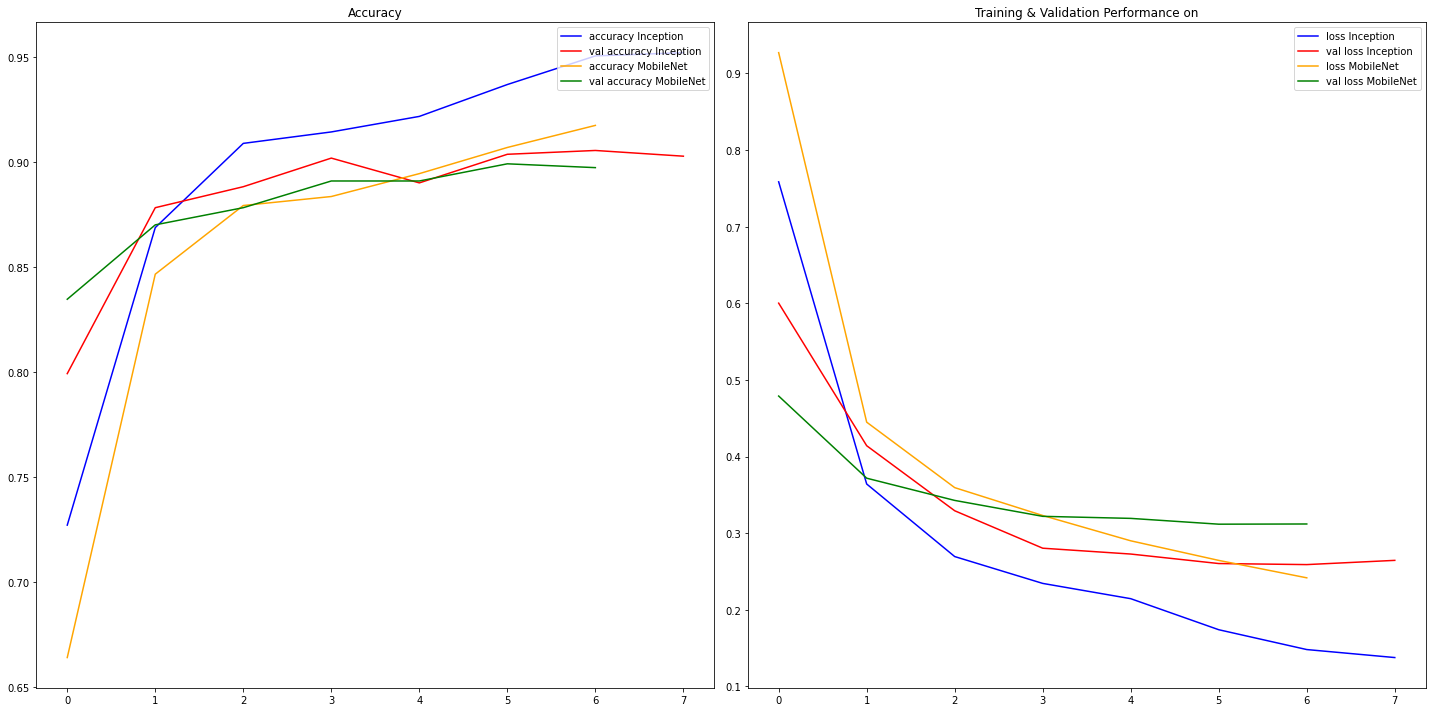

In [10]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

(train_data, val_data), meta = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:]'], 
                                        as_supervised=True, with_info=True)
num_train=meta.splits['train'].num_examples

EPOCHS=8
def define_model_inception():
    res=299
    URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

    model=tf.keras.Sequential([hub.KerasLayer(URL,
                        input_shape=(res,res,3), trainable=False),
                        tf.keras.layers.Dropout(0.15),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Dense(5, activation='softmax')])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        optimizer=tf.keras.optimizers.Adam()
    )
    return model,res
  
def define_model_mobilenet():
    res=224
    URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

    model=tf.keras.Sequential([hub.KerasLayer(URL,
                        input_shape=(res,res,3), trainable=False),
                        tf.keras.layers.Dropout(0.15),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.Dense(5, activation='softmax')])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        optimizer=tf.keras.optimizers.Adam()
    )
    return model, res
model, res=define_model_inception()

BATCH=50
classes=meta.features['label'].names

print('\n{}\n{}'.format(classes, num_train))

normalize= lambda data,labels: (tf.image.resize(data, (res, res))/255, labels)

train_batch=train_data.shuffle(buffer_size=num_train//2).map(normalize).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_batch=val_data.map(normalize).batch(BATCH).prefetch(tf.data.AUTOTUNE)

hist=model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=1)
)

model,res=define_model_mobilenet()
normalize= lambda data,labels: (tf.image.resize(data, (res, res))/255, labels)
train_batch=train_data.shuffle(buffer_size=num_train//2).map(normalize).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_batch=val_data.map(normalize).batch(BATCH).prefetch(tf.data.AUTOTUNE)
hist_mobile=model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=1)
)

def summarize_model_diagnostics(history, history_mob):
    loss, acc = history.history['loss'], history.history['accuracy']
    val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']
    loss_mob, acc_mob = history_mob.history['loss'], history_mob.history['accuracy']
    val_loss_mob, val_acc_mob = history_mob.history['val_loss'], history_mob.history['val_accuracy']
    fig, ax=plt.subplots(1,2, figsize=(20,10))
    ax[1].plot(loss, label='loss Inception',color='blue')
    ax[1].plot(val_loss, label='val loss Inception', color='r')
    ax[1].plot(loss_mob, label='loss MobileNet',color='orange')
    ax[1].plot(val_loss_mob, label='val loss MobileNet', color='green')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    ax[0].plot(acc, label='accuracy Inception',color='blue')
    ax[0].plot(val_acc, label='val accuracy Inception', color='r')
    ax[0].plot(acc_mob, label='accuracy MobileNet',color='orange')
    ax[0].plot(val_acc_mob, label='val accuracy MobileNet', color='green')
    ax[0].legend(loc='upper right')
    ax[0].set_title('Accuracy')
    plt.title('Training & Validation Performance on')
    plt.tight_layout()
    plt.show()
summarize_model_diagnostics(hist,hist_mobile)
